# install

In [38]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import random
import cv2
import os
import PIL
import pathlib
import splitfolders

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from keras.preprocessing.image import ImageDataGenerator
from keras.applications.vgg16 import VGG16

In [39]:
base_ds = '/content/drive/MyDrive/rice2'
base_ds = pathlib.Path(base_ds)

In [ ]:
!rm -rf /content/drive/MyDrive/rice2/saved_models

In [ ]:
splitfolders.ratio(base_ds, output='imgs', seed=123, ratio=(.8,.1,.1), group_prefix=None)

Copying files: 20000 files [04:10, 79.86 files/s] 


In [ ]:
japonica = [fn for fn in os.listdir(f'{base_ds}/japonica') if fn.endswith('.png')]
japonica1 = [fn for fn in os.listdir(f'{base_ds}/japonica1') if fn.endswith('.png')]
indica = [fn for fn in os.listdir(f'{base_ds}/indica') if fn.endswith('.png')]
indica1 = [fn for fn in os.listdir(f'{base_ds}/indica1') if fn.endswith('.png')]
rice = [japonica, japonica1, indica, indica1]
rice_classes = []
for i in os.listdir('imgs/train'):
    rice_classes+=[i]
rice_classes.sort()

In [ ]:
del rice_classes[0]

Total images: 19986
Total number of classes: 4
Total indica images: 5000
Total indica1 images: 5000
Total japonica images: 5000
Total japonica1 images: 5000


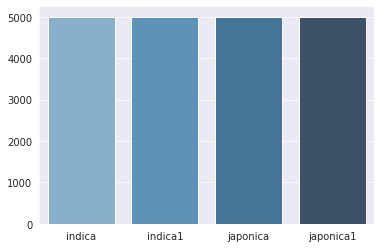

In [ ]:
image_count = len(list(base_ds.glob('*/*.png')))
print(f'Total images: {image_count}')
print(f'Total number of classes: {len(rice_classes)}')
count = 0
rice_count = []
for x in rice_classes:
  print(f'Total {x} images: {len(rice[count])}')
  rice_count.append(len(rice[count]))
  count += 0

sns.set_style('darkgrid')
sns.barplot(x=rice_classes, y=rice_count, palette="Blues_d")
plt.show()

In [ ]:
def load_random_img(dir, label):
  plt.figure(figsize=(10,10))
  i=0
  for label in rice_classes:
    i+=1
    plt.subplot(1, 4, i)
    file = random.choice(os.listdir(f'{dir}/{label}'))
    image_path = os.path.join(f'{dir}/{label}', file)
    img=cv2.imread(image_path)
    plt.title(label)
    plt.imshow(img)
    plt.grid(None)
    plt.axis('off')

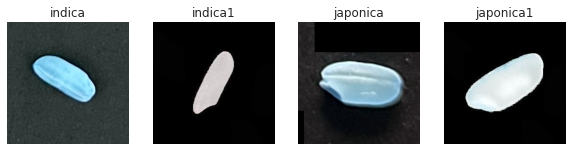

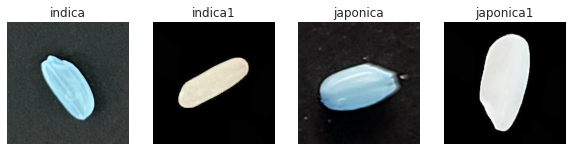

In [ ]:
for i in range(2):
  load_random_img(base_ds, rice_classes)

In [ ]:
batch_size = 128
img_height, img_width = 250, 250
input_shape = (img_height, img_width, 3)

# data pre-processing

In [ ]:
datagen = ImageDataGenerator(rescale=1./255)

In [ ]:
train_ds = datagen.flow_from_directory(
    'imgs/train',
    target_size = (img_height, img_width),
    batch_size = batch_size,
    subset = "training",
    class_mode='categorical')

val_ds = datagen.flow_from_directory(
    'imgs/val',
    target_size = (img_height, img_width),
    batch_size = batch_size,
    class_mode='categorical',
    shuffle=False)

test_ds = datagen.flow_from_directory(
    'imgs/test',
    target_size = (img_height, img_width),
    batch_size = batch_size,
    class_mode='categorical',
    shuffle=False)

In [ ]:
!rm -rf /content/drive/MyDrive/rice2/imgs/test/.ipynb_checkpoints
!rm -rf /content/drive/MyDrive/rice2/imgs/train/.ipynb_checkpoints
!rm -rf /content/drive/MyDrive/rice2/imgs/val/.ipynb_checkpoints

In [ ]:
test_ds.class_indices, val_ds.class_indices, train_ds.class_indices 

In [ ]:
def plot_train_history(history):
    plt.figure(figsize=(15,5))
    plt.subplot(1,2,1)
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc='upper left')
    
    plt.subplot(1,2,2)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc='upper left')
    plt.show()

def plot_

# vanilla CNN

In [ ]:
model_vanilla = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32,(3,3), activation='relu', input_shape=input_shape),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv2D(32,(3,3),activation='relu',padding='same'),
    tf.keras.layers.BatchNormalization(axis = 3),
    tf.keras.layers.MaxPooling2D(pool_size=(2,2),padding='same'),
    tf.keras.layers.Dropout(0.3),
    
    tf.keras.layers.Conv2D(64,(3,3),activation='relu',padding='same'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv2D(64,(3,3),activation='relu',padding='same'),
    tf.keras.layers.BatchNormalization(axis = 3),
    tf.keras.layers.MaxPooling2D(pool_size=(2,2),padding='same'),
    tf.keras.layers.Dropout(0.3),
    
    tf.keras.layers.Conv2D(128,(3,3),activation='relu',padding='same'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv2D(128,(3,3),activation='relu',padding='same'),
    tf.keras.layers.BatchNormalization(axis = 3),
    tf.keras.layers.MaxPooling2D(pool_size=(2,2),padding='same'),
    tf.keras.layers.Dropout(0.5),
    
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.25),
    tf.keras.layers.Dense(4, activation='softmax')
])

In [ ]:
model_vanilla.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model_vanilla.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_12 (Conv2D)          (None, 248, 248, 32)      896       
                                                                 
 batch_normalization_14 (Bat  (None, 248, 248, 32)     128       
 chNormalization)                                                
                                                                 
 conv2d_13 (Conv2D)          (None, 248, 248, 32)      9248      
                                                                 
 batch_normalization_15 (Bat  (None, 248, 248, 32)     128       
 chNormalization)                                                
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 124, 124, 32)     0         
 2D)                                                             
                                                      

# call back

In [ ]:
%load_ext tensorboard
logdir = os.path.join("logs")
n_thresholds=200
metrics = [
        tf.keras.metrics.AUC(name='AUC', curve='ROC'),
        tf.keras.metrics.AUC(name='AUPR', curve='PR'),
    ]
tensorboard_callback = tf.keras.callbacks.TensorBoard(logdir, histogram_freq=1)

In [ ]:
models_dir = "saved_models"
if not os.path.exists(models_dir):
    os.makedirs(models_dir)

checkpointer = ModelCheckpoint(filepath='saved_models/model_vanilla.hdf5', 
                               monitor='val_accuracy', mode='max',
                               verbose=1, save_best_only=True)
early_stopping = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2,patience=5, min_lr=0.0001)
callbacks=[early_stopping, reduce_lr, checkpointer, tensorboard_callback]

In [ ]:
history1 = model_vanilla.fit(train_ds, epochs = 40, validation_data = val_ds, callbacks=callbacks)

Epoch 1/40
125/125 [==============================] - ETA: 0s - loss: 0.0433 - accuracy: 0.9862
Epoch 1: val_accuracy improved from -inf to 0.25000, saving model to saved_models/model_vanilla.hdf5
125/125 [==============================] - 52s 405ms/step - loss: 0.0433 - accuracy: 0.9862 - val_loss: 27.1627 - val_accuracy: 0.2500 - lr: 0.0010
Epoch 2/40
125/125 [==============================] - ETA: 0s - loss: 0.0050 - accuracy: 0.9983
Epoch 2: val_accuracy did not improve from 0.25000
125/125 [==============================] - 48s 384ms/step - loss: 0.0050 - accuracy: 0.9983 - val_loss: 6.4211 - val_accuracy: 0.2500 - lr: 0.0010
Epoch 3/40
125/125 [==============================] - ETA: 0s - loss: 0.0073 - accuracy: 0.9979
Epoch 3: val_accuracy improved from 0.25000 to 0.44200, saving model to saved_models/model_vanilla.hdf5
125/125 [==============================] - 50s 399ms/step - loss: 0.0073 - accuracy: 0.9979 - val_loss: 12.5035 - val_accuracy: 0.4420 - lr: 0.0010
Epoch 4/40
12

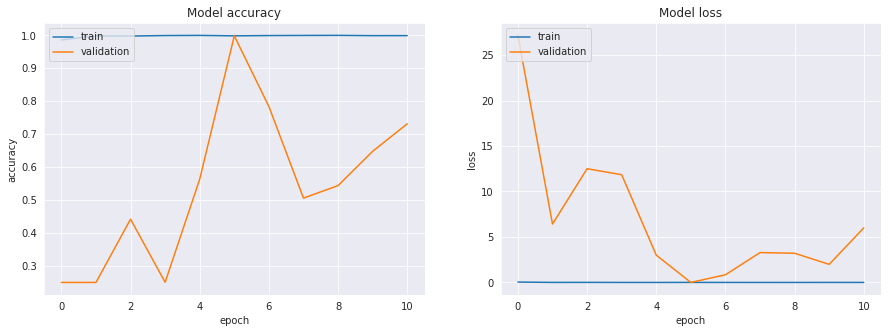

In [ ]:
model_vanilla.load_weights('saved_models/model_vanilla.hdf5')
plot_train_history(history1)

# evaluation

In [ ]:
score1 = model_vanilla.evaluate(test_ds, verbose=1)

16/16 [==============================] - 5s 305ms/step - loss: 0.0027 - accuracy: 0.9995


In [ ]:
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score

Y_pred = model_vanilla.predict(test_ds)

16/16 [==============================] - 5s 307ms/step


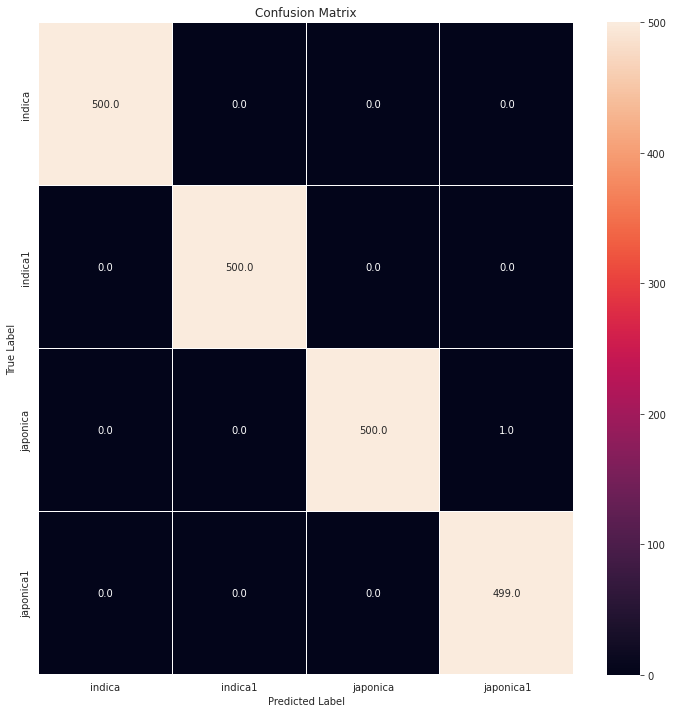

In [ ]:
y_pred = np.argmax(Y_pred, axis=1)
confusion_mtx = confusion_matrix(y_pred, test_ds.classes)
f,ax = plt.subplots(figsize=(12, 12))
sns.heatmap(confusion_mtx, annot=True, 
            linewidths=0.01,
            linecolor="white", 
            fmt= '.1f',ax=ax,)
sns.color_palette("rocket", as_cmap=True)

plt.xlabel("Predicted Label")
plt.ylabel("True Label")
ax.xaxis.set_ticklabels(test_ds.class_indices)
ax.yaxis.set_ticklabels(rice_classes)
plt.title("Confusion Matrix")
plt.show()

In [ ]:
report1 = classification_report(test_ds.classes, y_pred, target_names=rice_classes, output_dict=True)
df1 = pd.DataFrame(report1).transpose()
df1

,precision,recall,f1-score,support
indica,1.000000,1.0000,1.000000,500.0000
indica1,1.000000,1.0000,1.000000,500.0000
japonica,0.998004,1.0000,0.999001,500.0000
japonica1,1.000000,0.9980,0.998999,500.0000
accuracy,0.999500,0.9995,0.999500,0.9995
macro avg,0.999501,0.9995,0.999500,2000.0000
weighted avg,0.999501,0.9995,0.999500,2000.0000


# vanilla VGG16

In [ ]:
vgg16 = VGG16(weights="imagenet", include_top=False, input_shape=input_shape)
vgg16.trainable = False
inputs = tf.keras.Input(input_shape)
x = vgg16(inputs, training=False)
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dense(1024, activation='relu')(x)
x = tf.keras.layers.Dense(4, activation='softmax')(x)
model_vgg16 = tf.keras.Model(inputs, x)

58889256/58889256 [==============================] - 0s 0us/step


In [ ]:
model_vgg16.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model_vgg16.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 250, 250, 3)]     0         
                                                                 
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 global_average_pooling2d (G  (None, 512)              0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 1024)              525312    
                                                                 
 dense_1 (Dense)             (None, 4)                 4100      
                                                                 
Total params: 15,244,100
Trainable params: 529,412
Non-trainable params: 14,714,688
___________________________________________

In [ ]:
checkpointer = ModelCheckpoint(filepath='saved_models/vanilla_model_vgg16.hdf5', 
                               monitor='val_accuracy', mode='max',
                               verbose=1, save_best_only=True)
early_stopping = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=3)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2,patience=2, min_lr=0.001)
callbacks=[early_stopping, reduce_lr, checkpointer, tensorboard_callback]

In [ ]:
history2 = model_vgg16.fit(train_ds, epochs = 40, validation_data = val_ds, callbacks=callbacks)

In [ ]:
model_vgg16.load_weights('saved_models/vanilla_model_vgg16.hdf5')

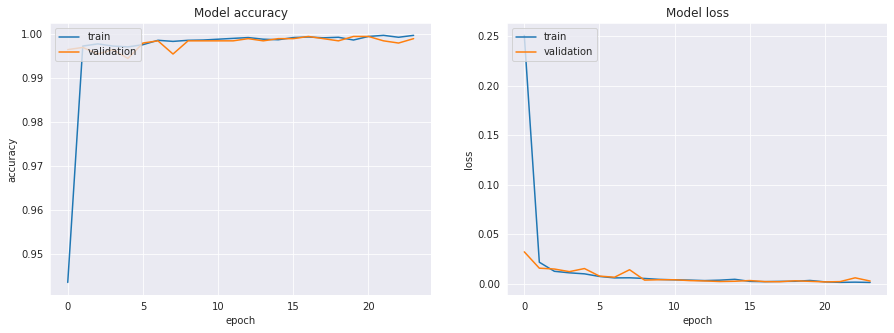

In [ ]:
plot_train_history(history2)

In [ ]:
score2 = model_vgg16.evaluate(test_ds, verbose=1)
print(f'Model 1 Vanilla Loss: {score1[0]}, Accuracy: {score1[1]*100}')
print(f'Model 2 VGG16 Loss: {score2[0]}, Accuracy: {score2[1]*100}')

16/16 [==============================] - 5s 307ms/step - loss: 0.0034 - accuracy: 0.9980
Model 1 Vanilla Loss: 0.0010842126794159412, Accuracy: 99.94999766349792
Model 2 VGG16 Loss: 0.003442251356318593, Accuracy: 99.80000257492065


# VGG16 Finetune

In [ ]:
vgg16.trainable = True
model_vgg16.compile(optimizer=keras.optimizers.Adam(1e-5),
              loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
history3 = model_vgg16.fit(train_ds, epochs = 40, validation_data = val_ds, callbacks=callbacks)

In [ ]:
model_vgg16.load_weights('saved_models/vanilla_model_vgg16.hdf5')

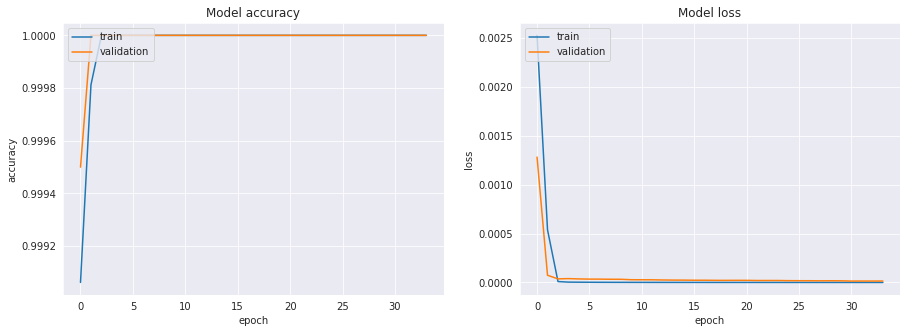

In [ ]:
plot_train_history(history3)

In [ ]:
score3 = model_vgg16.evaluate(test_ds, verbose=1)
print(f'Model 1 Vanilla Loss: {score1[0]}, Accuracy: {score1[1]*100}')
print(f'Model 2 VGG16 Loss: {score2[0]}, Accuracy: {score2[1]*100}')
print(f'Model 2 VGG16 Fine-tuned Loss: {score3[0]}, Accuracy: {score3[1]*100}')

16/16 [==============================] - 5s 308ms/step - loss: 1.1684e-04 - accuracy: 1.0000
Model 1 Vanilla Loss: 0.0010842126794159412, Accuracy: 99.94999766349792
Model 2 VGG16 Loss: 0.003442251356318593, Accuracy: 99.80000257492065
Model 2 VGG16 Fine-tuned Loss: 0.00011683625052683055, Accuracy: 100.0


In [ ]:
Y_pred = model_vgg16.predict(test_ds)

16/16 [==============================] - 5s 307ms/step


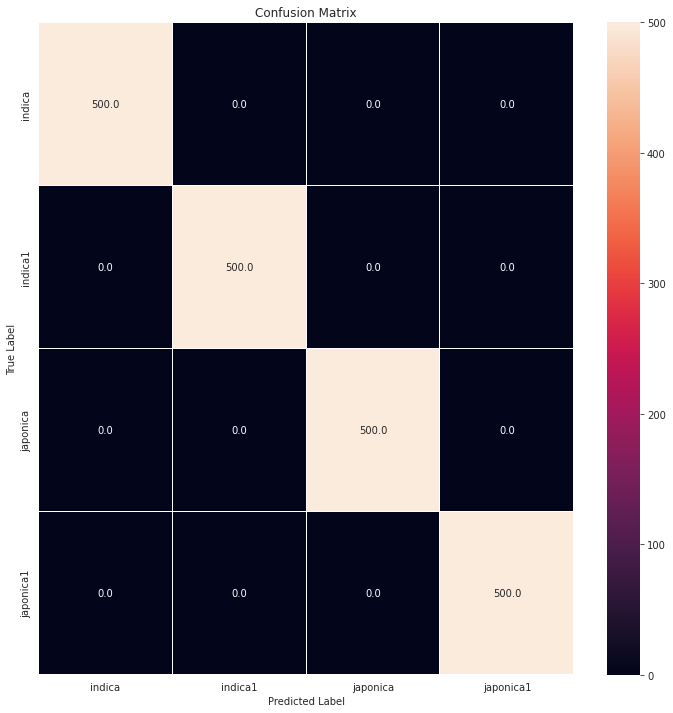

In [ ]:
y_pred = np.argmax(Y_pred, axis=1)
confusion_mtx = confusion_matrix(y_pred, test_ds.classes)
f,ax = plt.subplots(figsize=(12, 12))
sns.heatmap(confusion_mtx, annot=True, 
            linewidths=0.01,
            linecolor="white", 
            fmt= '.1f',ax=ax,)
sns.color_palette("rocket", as_cmap=True)

plt.xlabel("Predicted Label")
plt.ylabel("True Label")
ax.xaxis.set_ticklabels(test_ds.class_indices)
ax.yaxis.set_ticklabels(rice_classes)
plt.title("Confusion Matrix")
plt.show()

In [ ]:
report2 = classification_report(test_ds.classes, y_pred, target_names=rice_classes, output_dict=True)
df2 = pd.DataFrame(report1).transpose()
df2

,precision,recall,f1-score,support
indica,1.000000,1.0000,1.000000,500.0000
indica1,0.998004,1.0000,0.999001,500.0000
japonica,1.000000,1.0000,1.000000,500.0000
japonica1,1.000000,0.9980,0.998999,500.0000
accuracy,0.999500,0.9995,0.999500,0.9995
macro avg,0.999501,0.9995,0.999500,2000.0000
weighted avg,0.999501,0.9995,0.999500,2000.0000


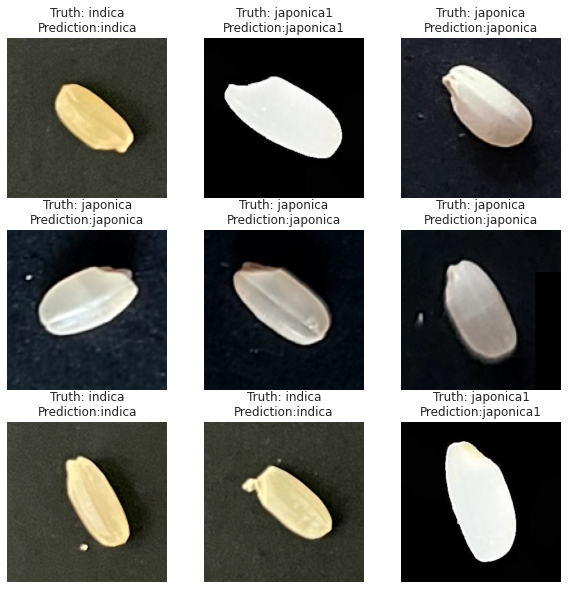

In [ ]:
plt.figure(figsize=(10, 10))
x, label= train_ds.next()
for i in range(9):
    plt.subplot(3, 3, i+1)
    plt.imshow(x[i])
    result = np.where(label[i]==1)
    predict = model_vgg16(tf.expand_dims(x[i], 0))
    score = tf.nn.softmax(predict[0])
    score_label = rice_classes[np.argmax(score)]
    plt.title(f'Truth: {rice_classes[result[0][0]]}\nPrediction:{score_label}')
    plt.axis(False)